# Estimacion de produccion de Gas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }
# plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import sys
sys.path.append('../serch_tools/')
import serch_tools as st

from pdpbox import pdp, info_plots
from sklearn.cluster import KMeans
import plotly
import cufflinks

In [2]:
aforos = pd.read_csv("aforos.csv")
analisis_fluidos = pd.read_csv("Analisis_fluidos.csv")
columna_geologica = pd.read_csv('columna_geologica.csv')
datos_generales_pozos = pd.read_csv('datos_generales_de_pozos.csv')
eval_petrofisica = pd.read_csv('eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('parametros_petrofisicos.csv')

In [3]:
reserva = pd.read_csv('reservas_2014.csv',nrows=3) # solo tiene 3 registros y muchos nulos

In [4]:
reserva

,index,REGION,ACTIVO,CAMPO,YACIMIENTO,CATEGORIA,FECHA_DE_CERTIFICACION_(dd/mm/aaaa),VOLUMEN_ORIGINAL_ACEITE_(mmb),VOLUMEN_ORIGINAL_GAS_NATURAL_(mmmpc),VOLUMEN_ORIGINAL_CONDENSADO_(mmb),...,FACTOR_DE_VOLUMEN_DEL_ACEITE@PRESION_INICIAL _(bls@cy/bls@cs),RELACION_CONDENSADO_GAS_(mb/mmpc),FACTOR_DE_VOLUMEN_DEL_GAS@PRESION_INICIAL_(pc@cy/pc@cs),RELACION_INICIAL_GAS_DISUELTO/ACEITE_ORIGINAL_ (mmpc/mb),FACTOR_DE_ENCOGIMIENTO_POR_LICUABLES_EN_EL_TRANSPORTE,FACTOR_DE_ENCOGIMIENTO_POR_IMPUREZAS,FACTOR_DE_ENCOGIMIENTO_LICUABLES_EN_PLANTA,FACTOR_DE_RECUPERACION _DE_CONDENSADO_(b/mpc),FACTOR_DE_RECUPERACION_DE_LIQUIDO_EN_PLANTA_(b/mpc),FACTOR_DE_EQUIVALENCIA_DEL_GAS_A_LIQUIDO_(b/mpc)
0,0,SPRS,APCP,Moloacán,Mioceno,1P,41640,221.70173,121.935952,0.0,...,1.127,NaN,NaN,0.549989,1,1,0.834292,0,0.106724,0.192273
1,1,SPRS,APCP,Moloacán,Mioceno,2P,41640,221.70173,121.935952,NaN,...,1.127,0.0,0.0,0.549989,1,1,0.834292,0,0.106724,0.192273
2,2,SPRS,APCP,Moloacán,Mioceno,3P,41640,221.70173,121.935952,0.0,...,1.127,NaN,0.0,0.549989,1,1,0.834292,0,0.106724,0.192273


In [5]:
prod_mens = pd.read_csv('produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [6]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [7]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [8]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [9]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

Text(0, 0.5, 'Produccion promedio')

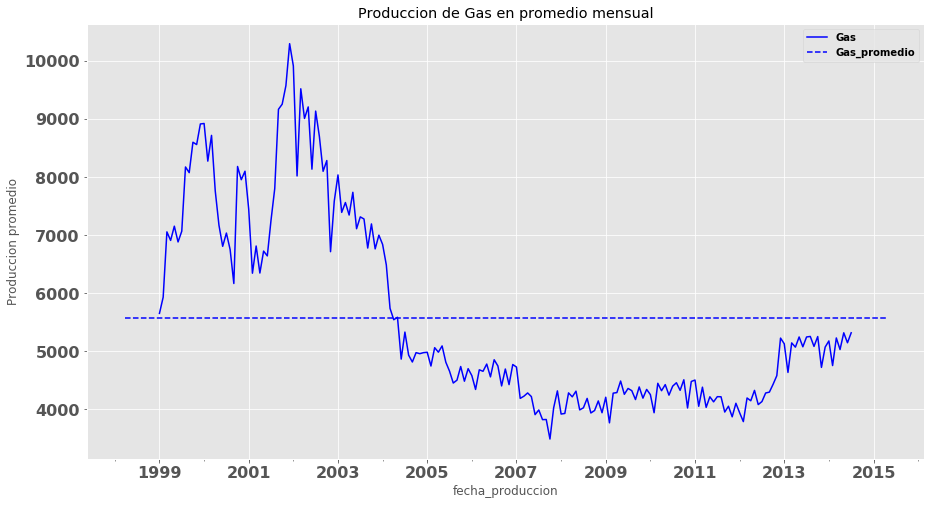

In [10]:
prod_mens.groupby('fecha_produccion').mean()['VOLUMEN_DE_GAS_(m3)'].plot(figsize=(15,8), 
                                                             title='Produccion de Gas en promedio mensual'
                                                            ,color='b')
mi,ma = plt.xlim()
plt.hlines(prod_mens.groupby('fecha_produccion').mean()['VOLUMEN_DE_GAS_(m3)'].mean(),
           mi, ma, color='b', linestyles='--')
plt.legend(['Gas','Gas_promedio'])
plt.ylabel('Produccion promedio')

120 Mediciones por plataforma en promedio tenemos

Text(0, 0.5, 'Produccion total en $10^5$')

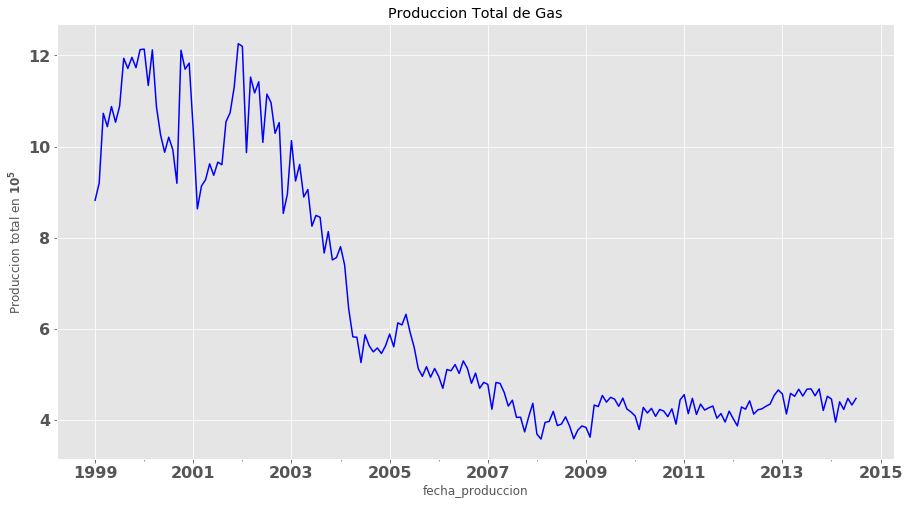

In [11]:
prod_total_liq = prod_mens.groupby('fecha_produccion')['VOLUMEN_DE_GAS_(m3)'].sum() / 1e5
prod_total_liq.plot(figsize=(15,8), title='Produccion Total de Gas', color='b')
plt.ylabel('Produccion total en $10^5$')

In [12]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION ',
       'fecha_produccion'],
      dtype='object')

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [13]:
db_prod_mol = pd.read_csv('DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [14]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [15]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [16]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


In [20]:
prod_mens.groupby('fecha_produccion').mean()['VOLUMEN_DE_GAS_(m3)'].head()

fecha_produccion
1999-01-01    5653.951312
1999-02-01    5933.686332
1999-03-01    7058.826328
1999-04-01    6911.508191
1999-05-01    7156.865590
Name: VOLUMEN_DE_GAS_(m3), dtype: float64

In [19]:
db_prod_mol.groupby('fecha_produccion').mean()['Qg_mes_MMpc'].head()

fecha_produccion
1999-01-01    0.199615
1999-02-01    0.209032
1999-03-01    0.249671
1999-04-01    0.243311
1999-05-01    0.252961
Name: Qg_mes_MMpc, dtype: float64

Text(0, 0.5, 'Produccion promedio')

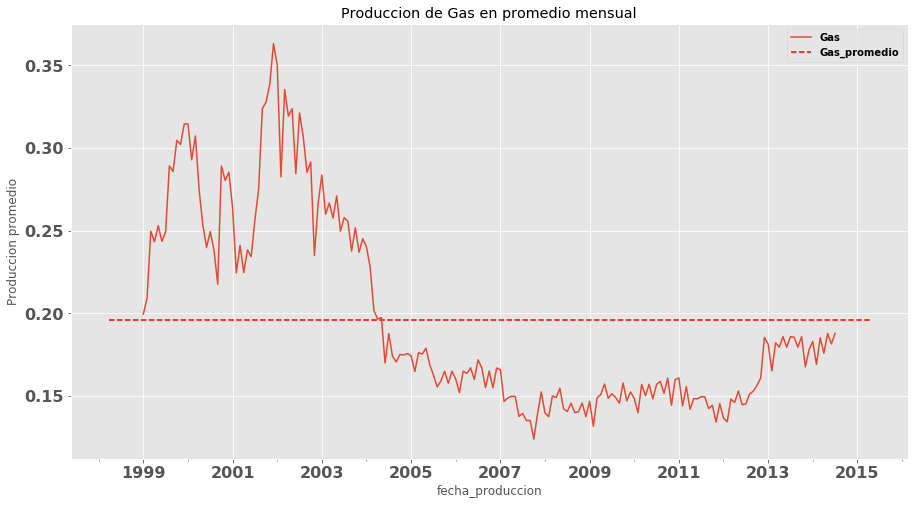

In [21]:
db_prod_mol.groupby('fecha_produccion').mean()['Qg_mes_MMpc'].plot(figsize=(15,8), 
                                                             title='Produccion de Gas en promedio mensual')
mi,ma = plt.xlim()
plt.hlines(db_prod_mol.groupby('fecha_produccion').mean()['Qg_mes_MMpc'].mean(),
           mi, ma, color='r', linestyles='--')
plt.legend(['Gas','Gas_promedio'])
plt.ylabel('Produccion promedio')

Se producen por plataforma 330 barriles mensuales CHECAR!!

Text(0, 0.5, 'Produccion total')

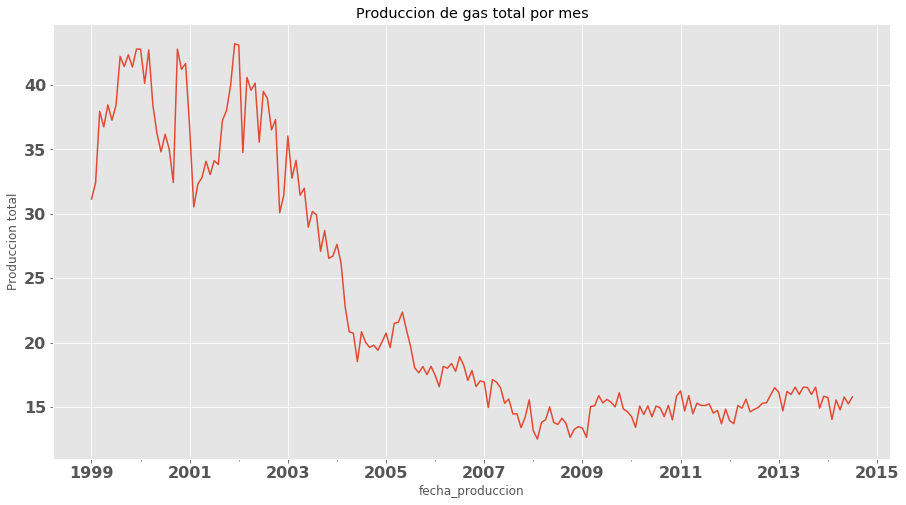

In [22]:
db_prod_mol.groupby('fecha_produccion').sum()['Qg_mes_MMpc'].plot(figsize=(15,8), 
                                                             title='Produccion de gas total por mes')

plt.ylabel('Produccion total')

264.518125

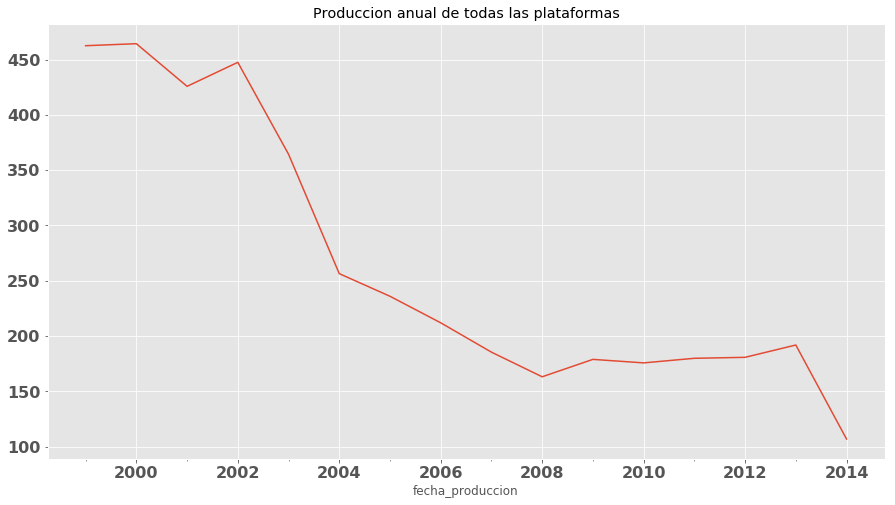

In [23]:
db_prod_mol.set_index('fecha_produccion').resample('Y').sum()['Qg_mes_MMpc'].plot(figsize=(15,8), 
title='Produccion anual de todas las plataformas')
db_prod_mol.set_index('fecha_produccion').resample('Y').sum()['Qg_mes_MMpc'].mean()

Anualmente se generan 264 MMpc barriles de petroleo CHECAR!!!

In [24]:
idx = db_prod_mol.Pozo.sample(3).values
sample = db_prod_mol[db_prod_mol.Pozo.isin(idx)]

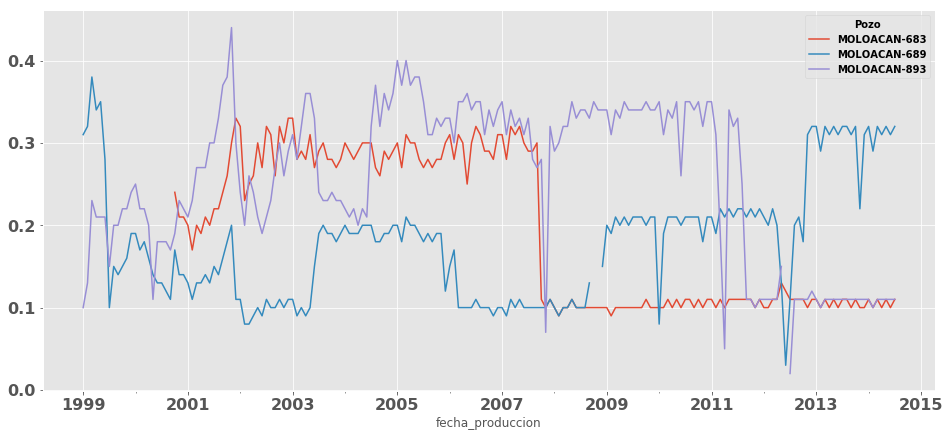

In [25]:
sample.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.sum().unstack(0).plot(figsize=(16,7))

# Numero de registros posibles para entrenamiento

In [26]:
print('Numero de plataformas: %i' % db_prod_mol.Pozo.nunique())

Numero de plataformas: 178


In [27]:
print('Numero de mediciones promedio por plataforma: %i' % db_prod_mol.groupby('Pozo').fecha_produccion.count().median())

Numero de mediciones promedio por plataforma: 124


In [28]:
a = 178 * 124

In [29]:
print('Alrededor de %i registros' % a)

Alrededor de 22072 registros


# Se estimara el numero de MMpc mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [31]:
# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first()

# tabla (t + 1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-1)

# tabla (t + 2)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-2)

# tabla (t + 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-3)

# tabla (t + 4)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-4)

# tabla (t + 4)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-5)

# tabla (t + 4)
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-6)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [32]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6],1).dropna()
df.columns = ['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4',
              'Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1','Qg_mes_MMpc_t']

In [33]:
df.shape # numero de registros

(20880, 7)

In [34]:
df['diff_t_6_t_5'] = df.Qg_mes_MMpc_t_6 - df.Qg_mes_MMpc_t_5
df['diff_t_5_t_4'] = df.Qg_mes_MMpc_t_5 - df.Qg_mes_MMpc_t_4
df['diff_t_4_t_3'] = df.Qg_mes_MMpc_t_4 - df.Qg_mes_MMpc_t_3
df['diff_t_3_t_2'] = df.Qg_mes_MMpc_t_3 - df.Qg_mes_MMpc_t_2
df['diff_t_2_t_1'] = df.Qg_mes_MMpc_t_2 - df.Qg_mes_MMpc_t_1

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [35]:
df['std_t_6_t_1'] = df[['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4','Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1']].std(1)
df['mean_t_6_t_1'] = df[['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4','Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1']].mean(1)
df['median_t_6_t_1'] = df[['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4','Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1']].median(1)
df['min_t_6_t_1'] = df[['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4','Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1']].min(1)
df['max_t_6_t_1'] = df[['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4','Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1']].max(1)

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor

In [36]:
# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Dias_de_Operacion.first()

# tabla (t + 1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Dias_de_Operacion.first().shift(-1)

# tabla (t + 2)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Dias_de_Operacion.first().shift(-2)

# tabla (t + 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Dias_de_Operacion.first().shift(-3)

# tabla (t + 4)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Dias_de_Operacion.first().shift(-4)

# tabla (t + 5)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Dias_de_Operacion.first().shift(-5)

In [37]:
df_days = pd.concat([t,t_1,t_2,t_3,t_4,t_5],1).dropna()
df_days.columns = ['Dias_de_Operacion_t_6','Dias_de_Operacion_t_5','Dias_de_Operacion_t_4',
              'Dias_de_Operacion_t_3','Dias_de_Operacion_t_2','Dias_de_Operacion_t_1']

In [38]:
df = pd.merge(df, df_days, right_index=True, left_index=True)

In [39]:
df.head(8)

Qg_mes_MMpc_t_6  Qg_mes_MMpc_t_5  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.03             0.05   
              2002-07-01                   0.05             0.22   
              2002-08-01                   0.22             0.21   
              2002-09-01                   0.21             0.22   
              2002-10-01                   0.22             0.02   
              2002-11-01                   0.02             0.18   
              2003-01-01                   0.18             0.22   
              2003-02-01                   0.22             0.20   

                                Qg_mes_MMpc_t_4  Qg_mes_MMpc_t_3  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.22             0.21   
              2002-07-01                   0.21             0.22   
              2002-08-01                   0.22             0.02   
              2002-09-01                   0.02             0.18   
              2002-10-01                   0.18             0.22   
              2002-11-01                   0.22             0.20   
              2003-01-01                   0.20             0.08   
              2003-02-01                   0.08             0.07   

                                Qg_mes_MMpc_t_2  Qg_mes_MMpc_t_1  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.22             0.02   
              2002-07-01                   0.02             0.18   
              2002-08-01                   0.18             0.22   
              2002-09-01                   0.22             0.20   
              2002-10-01                   0.20             0.08   
              2002-11-01                   0.08             0.07   
              2003-01-01                   0.07             0.07   
              2003-02-01                   0.07             0.09   

                                Qg_mes_MMpc_t  diff_t_6_t_5  diff_t_5_t_4  \
Pozo          fecha_produccion                                              
MOLOACAN-1004 2002-06-01                 0.18         -0.02         -0.17   
              2002-07-01                 0.22         -0.17          0.01   
              2002-08-01                 0.20          0.01         -0.01   
              2002-09-01                 0.08         -0.01          0.20   
              2002-10-01                 0.07          0.20         -0.16   
              2002-11-01                 0.07         -0.16         -0.04   
              2003-01-01                 0.09         -0.04          0.02   
              2003-02-01                 0.09          0.02          0.12   

                                diff_t_4_t_3          ...            \
Pozo          fecha_produccion                        ...             
MOLOACAN-1004 2002-06-01                0.01          ...             
              2002-07-01               -0.01          ...             
              2002-08-01                0.20          ...             
              2002-09-01               -0.16          ...             
              2002-10-01               -0.04          ...             
              2002-11-01                0.02          ...             
              2003-01-01                0.12          ...             
              2003-02-01                0.01          ...             

                                mean_t_6_t_1  median_t_6_t_1  min_t_6_t_1  \
Pozo          fecha_produccion                                              
MOLOACAN-1004 2002-06-01            0.125000           0.130         0.02   
              2002-07-01            0.150000           0.195         0.02   
              2002-08-01            0.178333           0.215         0.02   
              2002-09-01            0.175000           0.205         0.02   
              2002-10-01            0.153333 

In [40]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

In [41]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [42]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Generar pico historico

## Si estuvo detenido

In [43]:
detenido_mes_anterior = pd.DataFrame(np.where((db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D") > 31, 1, 0), index=db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
detenido_mes_anterior.head()

detenido_mes_antes
Pozo          fecha_produccion                    
MOLOACAN-1004 2002-06-01                         1
              2002-07-01                         0
              2002-08-01                         0
              2002-09-01                         0
              2002-10-01                         0

In [44]:
df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Variables de historico de agua y gas

In [45]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion', 'fecha_produccion', 'f_prod'],
      dtype='object')

In [46]:
# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t + 1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t + 2)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t + 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t + 4)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t + 5)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

In [47]:
df_gas = pd.concat([t,t_1,t_2,t_3,t_4,t_5],1).dropna()
df_gas.columns = ['Qo_mes_b_t_6','Qo_mes_b_t_5','Qo_mes_b_t_4',
              'Qo_mes_b_t_3','Qo_mes_b_t_2','Qo_mes_b_t_1']

In [48]:
df = pd.merge(df, df_gas, right_index=True, left_index=True)

In [49]:
df.head(8)

Qg_mes_MMpc_t_6  Qg_mes_MMpc_t_5  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.03             0.05   
              2002-07-01                   0.05             0.22   
              2002-08-01                   0.22             0.21   
              2002-09-01                   0.21             0.22   
              2002-10-01                   0.22             0.02   
              2002-11-01                   0.02             0.18   
              2003-01-01                   0.18             0.22   
              2003-02-01                   0.22             0.20   

                                Qg_mes_MMpc_t_4  Qg_mes_MMpc_t_3  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.22             0.21   
              2002-07-01                   0.21             0.22   
              2002-08-01                   0.22             0.02   
              2002-09-01                   0.02             0.18   
              2002-10-01                   0.18             0.22   
              2002-11-01                   0.22             0.20   
              2003-01-01                   0.20             0.08   
              2003-02-01                   0.08             0.07   

                                Qg_mes_MMpc_t_2  Qg_mes_MMpc_t_1  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.22             0.02   
              2002-07-01                   0.02             0.18   
              2002-08-01                   0.18             0.22   
              2002-09-01                   0.22             0.20   
              2002-10-01                   0.20             0.08   
              2002-11-01                   0.08             0.07   
              2003-01-01                   0.07             0.07   
              2003-02-01                   0.07             0.09   

                                Qg_mes_MMpc_t  diff_t_6_t_5  diff_t_5_t_4  \
Pozo          fecha_produccion                                              
MOLOACAN-1004 2002-06-01                 0.18         -0.02         -0.17   
              2002-07-01                 0.22         -0.17          0.01   
              2002-08-01                 0.20          0.01         -0.01   
              2002-09-01                 0.08         -0.01          0.20   
              2002-10-01                 0.07          0.20         -0.16   
              2002-11-01                 0.07         -0.16         -0.04   
              2003-01-01                 0.09         -0.04          0.02   
              2003-02-01                 0.09          0.02          0.12   

                                diff_t_4_t_3      ...       month_10  \
Pozo          fecha_produccion                    ...                  
MOLOACAN-1004 2002-06-01                0.01      ...              0   
              2002-07-01               -0.01      ...              0   
              2002-08-01                0.20      ...              0   
              2002-09-01               -0.16      ...              0   
              2002-10-01               -0.04      ...              0   
              2002-11-01                0.02      ...              0   
              2003-01-01                0.12      ...              0   
              2003-02-01                0.01      ...              0   

                                month_11  month_12  detenido_mes_antes  \
Pozo          fecha_produccion                                           
MOLOACAN-1004 2002-06-01               0         0                   1   
              2002-07-01               0         0                   0   
              2002-08-01               0         0                   0   
              2002-09-01               0         0                   0   
              2002-10-01               0         0   

In [50]:
# tabla (t-6)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qw_mes_b.first()

# tabla (t - 5)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qw_mes_b.first().shift(-1)

# tabla (t - 4)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qw_mes_b.first().shift(-2)

# tabla (t - 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qw_mes_b.first().shift(-3)

# tabla (t - 2)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qw_mes_b.first().shift(-4)

# tabla (t - 1)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qw_mes_b.first().shift(-5)

In [51]:
df_water = pd.concat([t,t_1,t_2,t_3,t_4,t_5],1).dropna()
df_water.columns = ['Qwater_mes_b_t_6','Qwater_mes_b_t_5','Qwater_mes_b_t_4',
              'Qwater_mes_b_t_3','Qwater_mes_b_t_2','Qwater_mes_b_t_1']

In [52]:
df = pd.merge(df, df_water, right_index=True, left_index=True)

In [53]:
df.head(8)

Qg_mes_MMpc_t_6  Qg_mes_MMpc_t_5  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.03             0.05   
              2002-07-01                   0.05             0.22   
              2002-08-01                   0.22             0.21   
              2002-09-01                   0.21             0.22   
              2002-10-01                   0.22             0.02   
              2002-11-01                   0.02             0.18   
              2003-01-01                   0.18             0.22   
              2003-02-01                   0.22             0.20   

                                Qg_mes_MMpc_t_4  Qg_mes_MMpc_t_3  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.22             0.21   
              2002-07-01                   0.21             0.22   
              2002-08-01                   0.22             0.02   
              2002-09-01                   0.02             0.18   
              2002-10-01                   0.18             0.22   
              2002-11-01                   0.22             0.20   
              2003-01-01                   0.20             0.08   
              2003-02-01                   0.08             0.07   

                                Qg_mes_MMpc_t_2  Qg_mes_MMpc_t_1  \
Pozo          fecha_produccion                                     
MOLOACAN-1004 2002-06-01                   0.22             0.02   
              2002-07-01                   0.02             0.18   
              2002-08-01                   0.18             0.22   
              2002-09-01                   0.22             0.20   
              2002-10-01                   0.20             0.08   
              2002-11-01                   0.08             0.07   
              2003-01-01                   0.07             0.07   
              2003-02-01                   0.07             0.09   

                                Qg_mes_MMpc_t  diff_t_6_t_5  diff_t_5_t_4  \
Pozo          fecha_produccion                                              
MOLOACAN-1004 2002-06-01                 0.18         -0.02         -0.17   
              2002-07-01                 0.22         -0.17          0.01   
              2002-08-01                 0.20          0.01         -0.01   
              2002-09-01                 0.08         -0.01          0.20   
              2002-10-01                 0.07          0.20         -0.16   
              2002-11-01                 0.07         -0.16         -0.04   
              2003-01-01                 0.09         -0.04          0.02   
              2003-02-01                 0.09          0.02          0.12   

                                diff_t_4_t_3        ...         Qo_mes_b_t_4  \
Pozo          fecha_produccion                      ...                        
MOLOACAN-1004 2002-06-01                0.01        ...                 0.22   
              2002-07-01               -0.01        ...                 0.21   
              2002-08-01                0.20        ...                 0.22   
              2002-09-01               -0.16        ...                 0.02   
              2002-10-01               -0.04        ...                 0.18   
              2002-11-01                0.02        ...                 0.22   
              2003-01-01                0.12        ...                 0.20   
              2003-02-01                0.01        ...                 0.08   

                                Qo_mes_b_t_3  Qo_mes_b_t_2  Qo_mes_b_t_1  \
Pozo          fecha_produccion                                             
MOLOACAN-1004 2002-06-01                0.21          0.22          0.02   
              2002-07-01                0.22          0.02          0.18   
              2002-08-01                0.02          0.18          0.22   
              2002-09-01             

In [54]:
df_train = df.reset_index()

In [55]:
df_train.shape

(20880, 50)

## Quitamos Outliers

In [56]:
df_train = df_train[df_train.Qg_mes_MMpc_t > df_train.Qg_mes_MMpc_t.quantile(0.005)]
df_train = df_train[df_train.Qg_mes_MMpc_t_1 > df_train.Qg_mes_MMpc_t_1.quantile(0.001)]
df_train = df_train[df_train.Qg_mes_MMpc_t_2 > df_train.Qg_mes_MMpc_t_2.quantile(0.001)]
df_train = df_train[df_train.Qg_mes_MMpc_t_3 > df_train.Qg_mes_MMpc_t_3.quantile(0.001)]
df_train = df_train[df_train.Qg_mes_MMpc_t_4 > df_train.Qg_mes_MMpc_t_4.quantile(0.001)]
df_train = df_train[df_train.Qg_mes_MMpc_t_5 > df_train.Qg_mes_MMpc_t_5.quantile(0.001)]
df_train = df_train[df_train.Qg_mes_MMpc_t_6 > df_train.Qg_mes_MMpc_t_6.quantile(0.001)]

In [57]:
df_train = df_train[df_train.Qg_mes_MMpc_t < df_train.Qg_mes_MMpc_t.quantile(0.99)]

In [58]:
df_train = df_train[df_train.Qg_mes_MMpc_t_1 < df_train.Qg_mes_MMpc_t_1.quantile(0.99)]
df_train = df_train[df_train.Qg_mes_MMpc_t_2 < df_train.Qg_mes_MMpc_t_2.quantile(0.99)]
df_train = df_train[df_train.Qg_mes_MMpc_t_3 < df_train.Qg_mes_MMpc_t_3.quantile(0.99)]
df_train = df_train[df_train.Qg_mes_MMpc_t_4 < df_train.Qg_mes_MMpc_t_4.quantile(0.99)]
df_train = df_train[df_train.Qg_mes_MMpc_t_5 < df_train.Qg_mes_MMpc_t_5.quantile(0.99)]
df_train = df_train[df_train.Qg_mes_MMpc_t_6 < df_train.Qg_mes_MMpc_t_6.quantile(0.99)]

In [59]:
df_train.reset_index(inplace=True, drop=True)

In [60]:
df_train.shape

(18847, 50)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [61]:
from sklearn.cluster import KMeans

In [62]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'Qg_mes_MMpc_t', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1'],
      dtype='object')

In [63]:
num_cols = ['Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'Qg_mes_MMpc_t', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1']

In [64]:
df_std = (df_train[num_cols] - df_train[num_cols].mean() )/ df_train[num_cols].std()

In [65]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

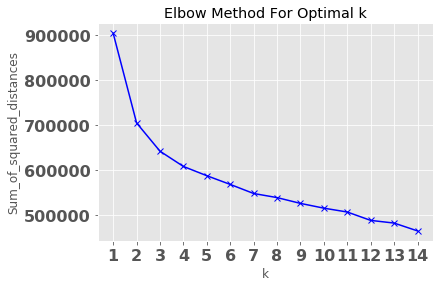

In [66]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [67]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [68]:
df_train = pd.concat([df_train,pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [69]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [70]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'Qg_mes_MMpc_t', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'c

In [71]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latiutd', 'longitud']
lat_lon_pozo.head()

,Pozo,latiutd,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [72]:
df_train = df_train.merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [73]:
df_train.head()

,Pozo,fecha_produccion,Qg_mes_MMpc_t_6,Qg_mes_MMpc_t_5,Qg_mes_MMpc_t_4,Qg_mes_MMpc_t_3,Qg_mes_MMpc_t_2,Qg_mes_MMpc_t_1,Qg_mes_MMpc_t,diff_t_6_t_5,...,Qwater_mes_b_t_1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latiutd,longitud
200,MOLOACAN-111,1999-01-01,0.10,0.10,0.20,0.16,0.14,0.12,0.10,0.00,...,45.76,0,0,1,0,0,0,2,17.985929,-94.370707
201,MOLOACAN-111,1999-02-01,0.10,0.20,0.16,0.14,0.12,0.10,0.13,-0.10,...,47.87,0,0,1,0,0,0,2,17.985929,-94.370707
202,MOLOACAN-111,1999-03-01,0.20,0.16,0.14,0.12,0.10,0.13,0.14,0.04,...,43.89,0,0,1,0,0,0,2,17.985929,-94.370707
203,MOLOACAN-111,1999-04-01,0.16,0.14,0.12,0.10,0.13,0.14,0.15,0.02,...,44.76,0,0,1,0,0,0,2,17.985929,-94.370707
204,MOLOACAN-111,1999-05-01,0.14,0.12,0.10,0.13,0.14,0.15,0.15,0.02,...,47.10,0,0,1,0,0,0,2,17.985929,-94.370707


In [74]:
df_train.shape

(18468, 59)

# AED

Text(0.5, 1.0, 'Histograma de variable predictiva')

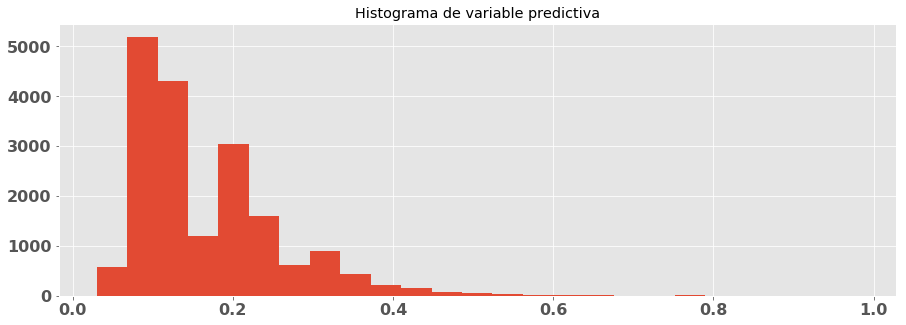

In [77]:
df_train.Qg_mes_MMpc_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
# plt.xticks(np.linspace(0,4000,15));

## Se tiene que probar predecir con logaritmo de produccion

In [78]:
df_train["Qg_mes_MMpc_t_log"] = np.log(1 + df_train.Qg_mes_MMpc_t)

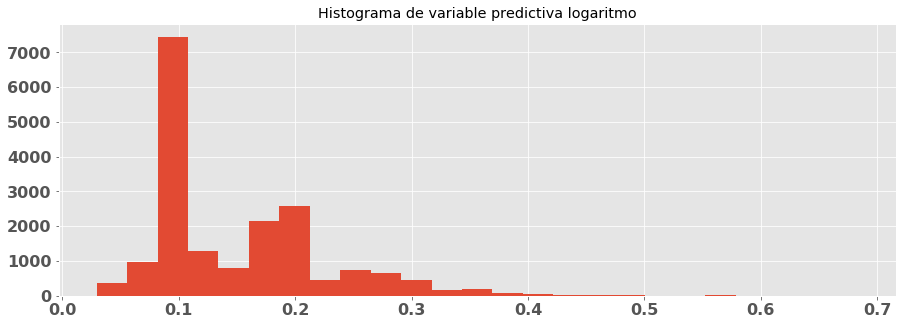

In [79]:
df_train.Qg_mes_MMpc_t_log.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva logaritmo');

# Dispersiones

In [80]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'Qg_mes_MMpc_t', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'c

In [81]:
num_cols = ['Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'latiutd', 'longitud']

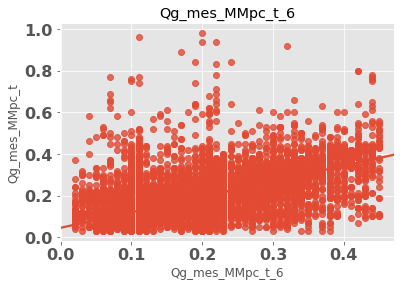

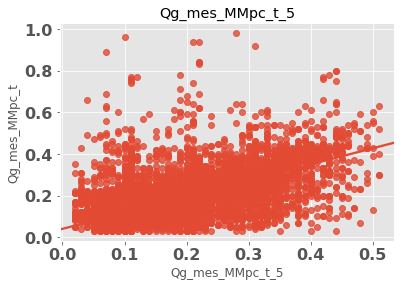

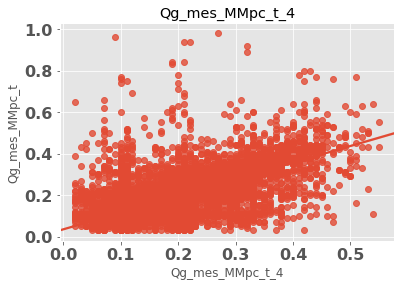

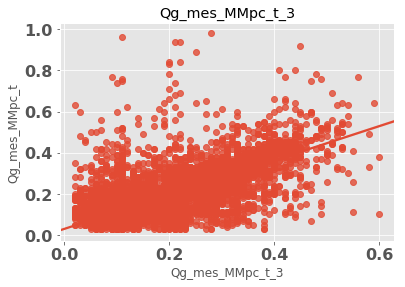

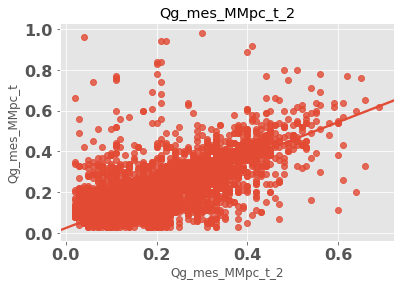

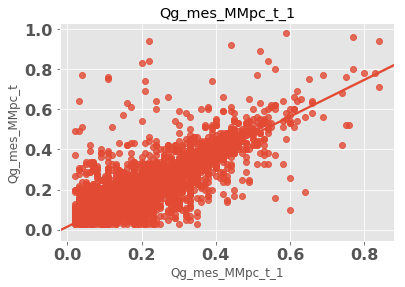

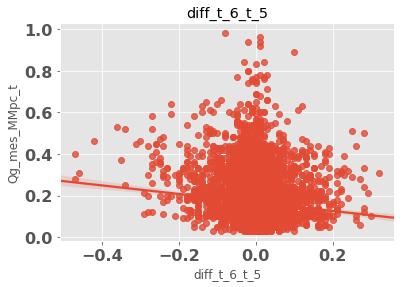

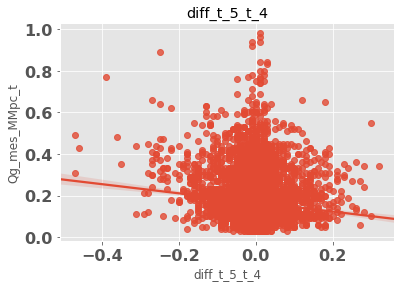

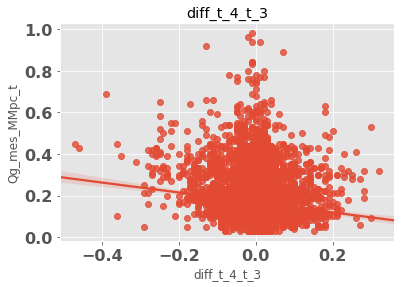

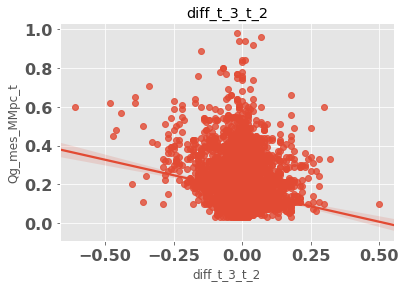

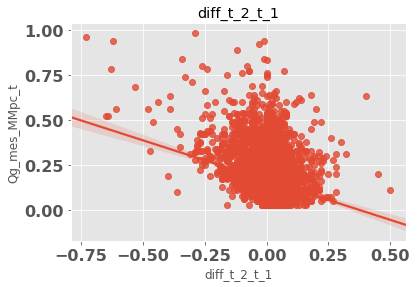

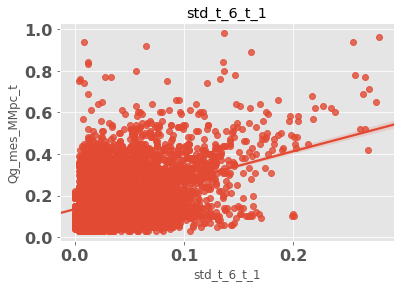

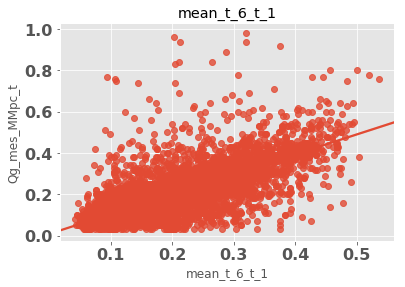

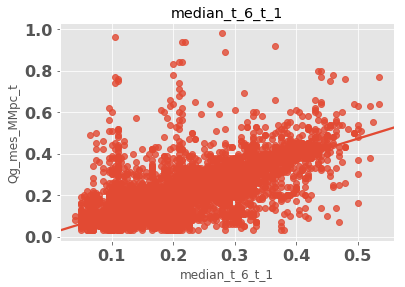

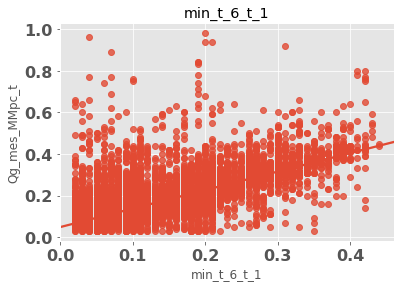

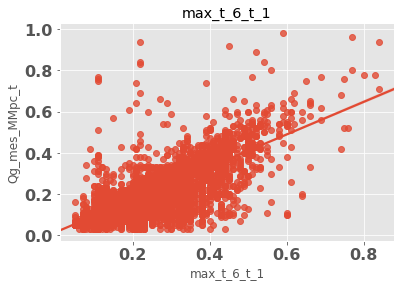

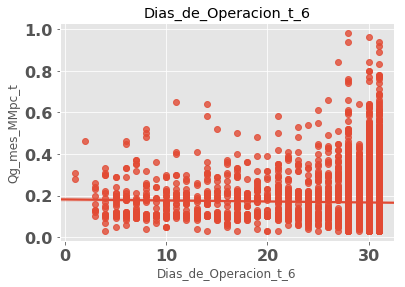

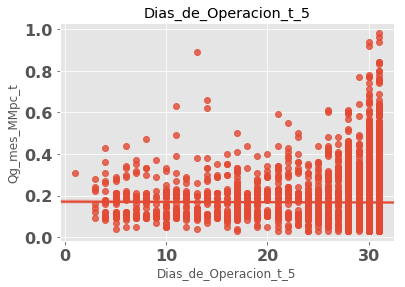

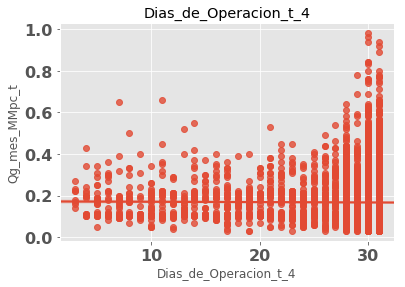

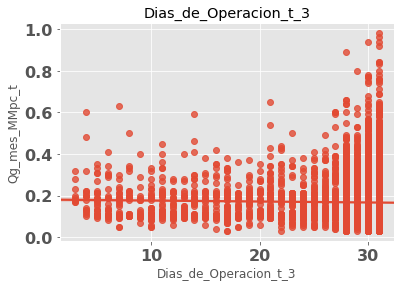

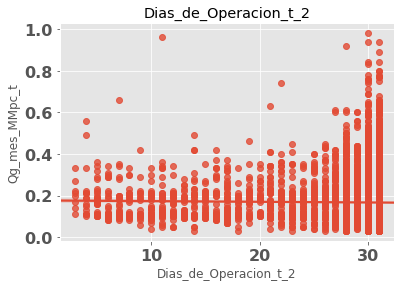

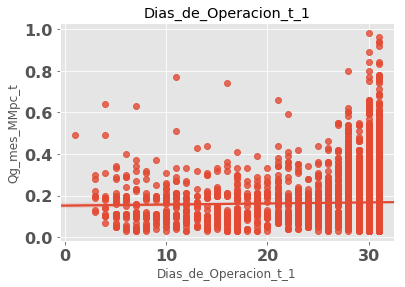

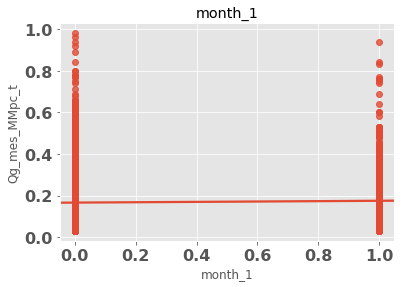

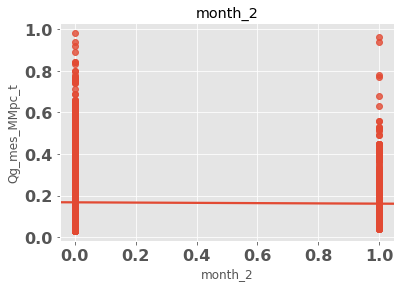

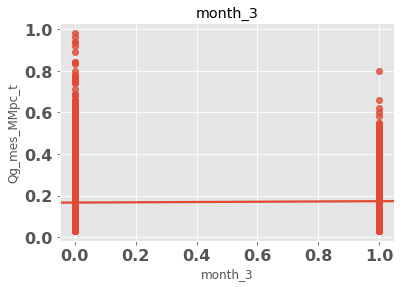

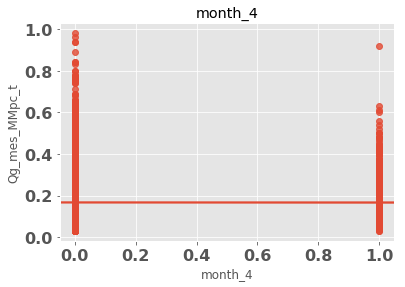

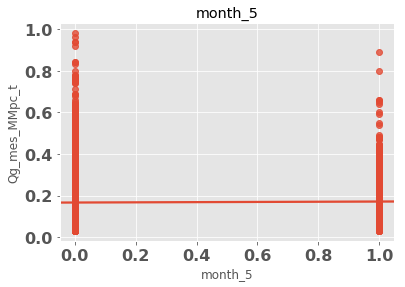

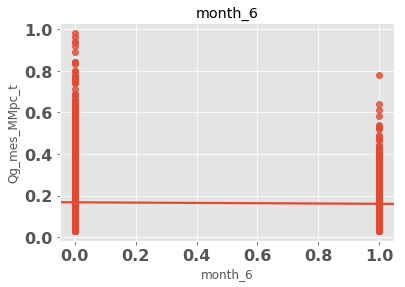

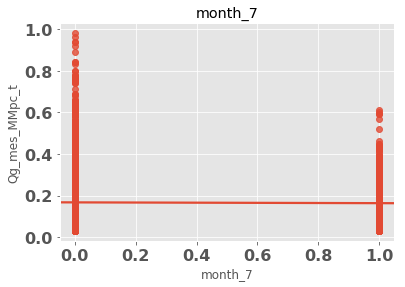

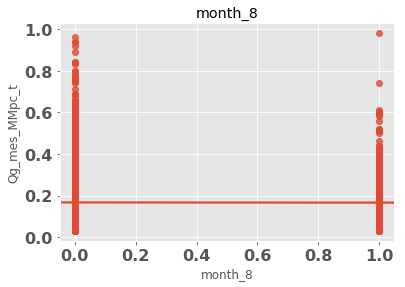

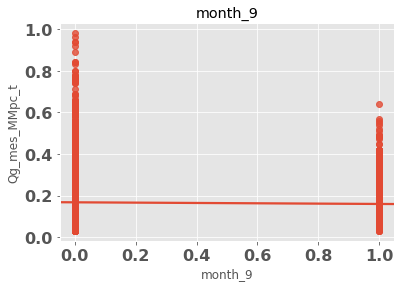

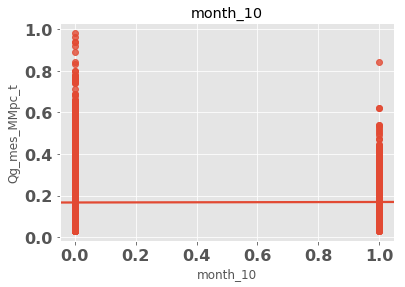

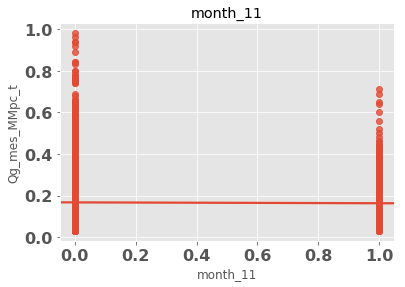

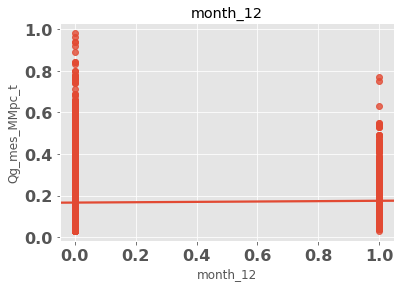

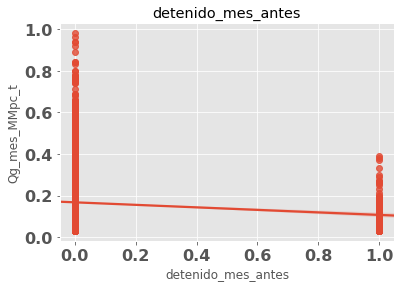

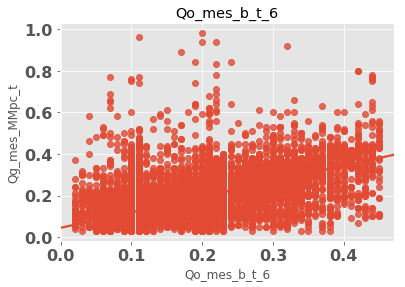

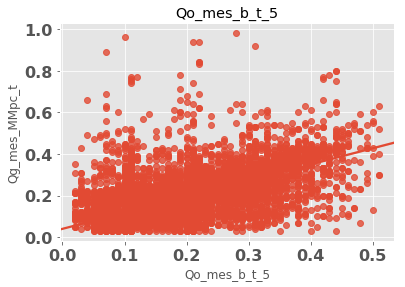

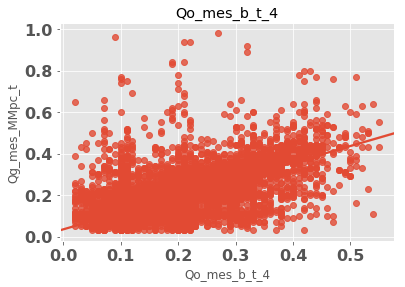

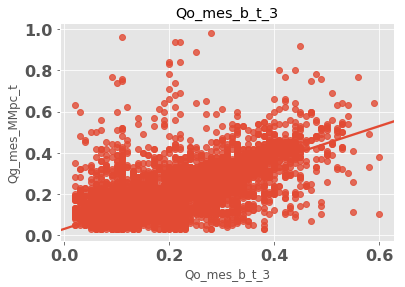

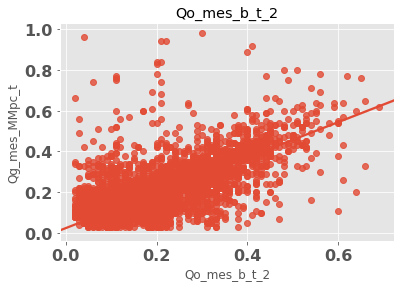

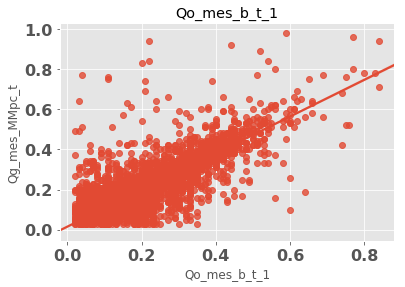

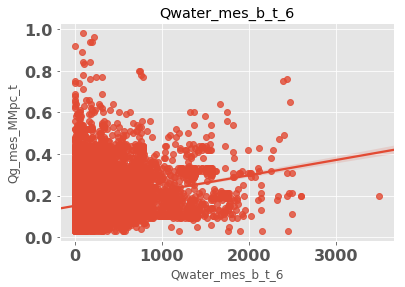

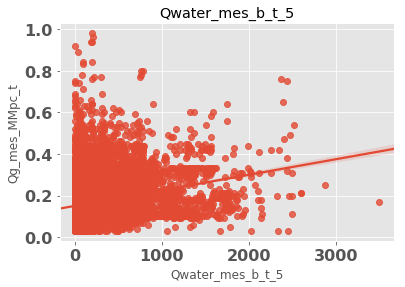

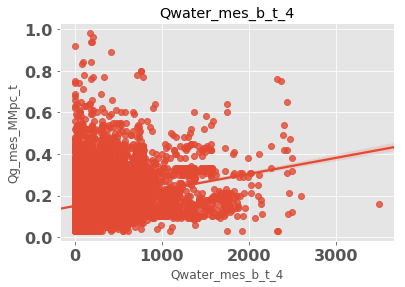

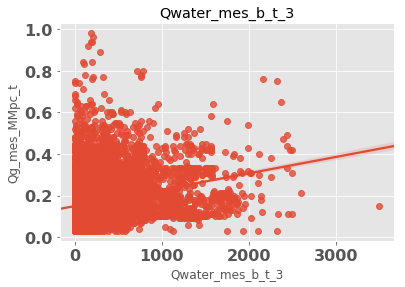

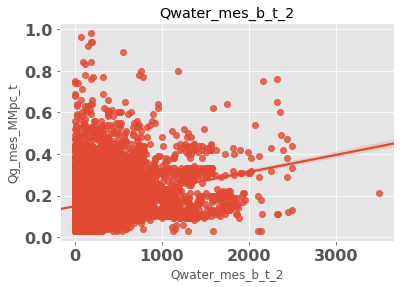

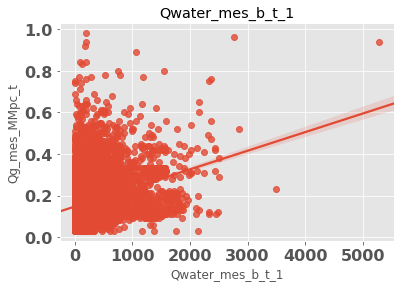

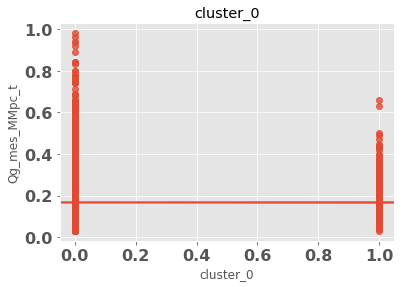

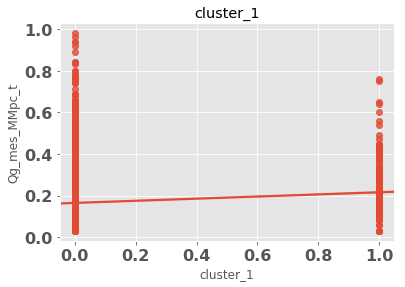

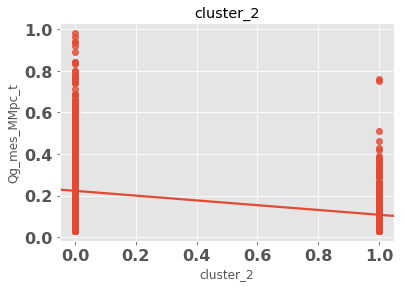

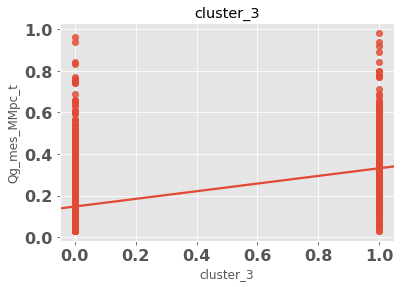

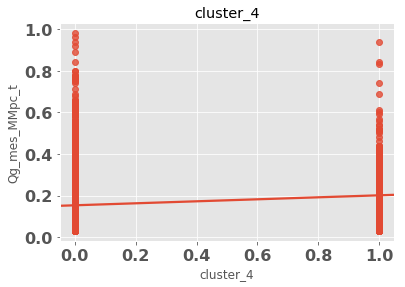

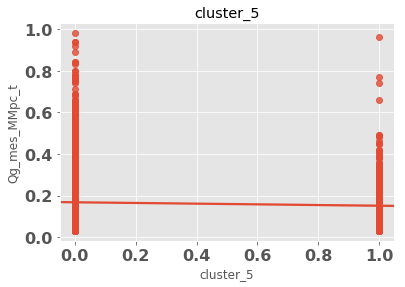

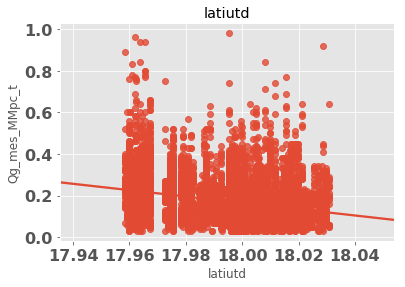

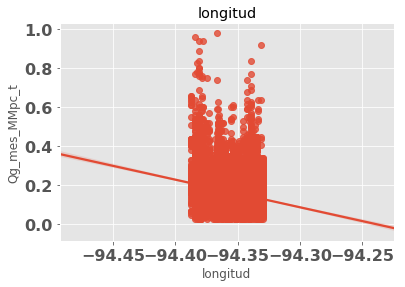

In [83]:
for i in df_train[num_cols].columns:
    plt.subplots()
    sns.regplot(df_train[i],df_train.Qg_mes_MMpc_t)
    plt.title(i)

En algunas dispersiones vemos que hay como dos conjuntos que se comportan distinto... posible crear variables

In [84]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'Qg_mes_MMpc_t', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'c

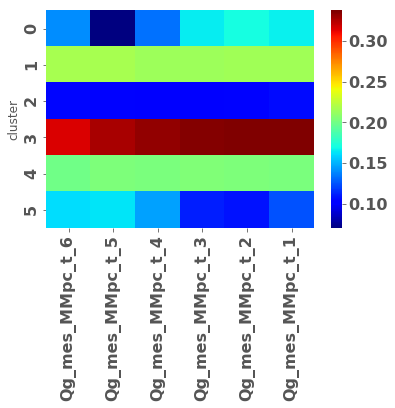

In [86]:
sns.heatmap(df_train.groupby('cluster')[['Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1']].mean(),cmap='jet')

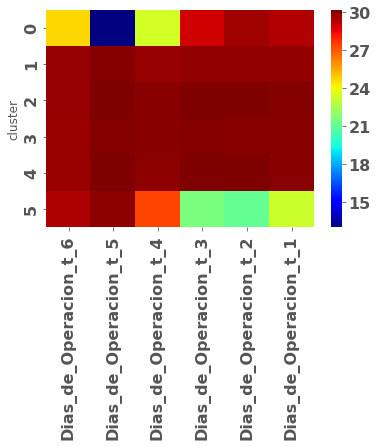

In [87]:
sns.heatmap(df_train.groupby('cluster')[['Dias_de_Operacion_t_6',
       'Dias_de_Operacion_t_5', 'Dias_de_Operacion_t_4',
       'Dias_de_Operacion_t_3', 'Dias_de_Operacion_t_2',
       'Dias_de_Operacion_t_1']].mean(),cmap='jet')

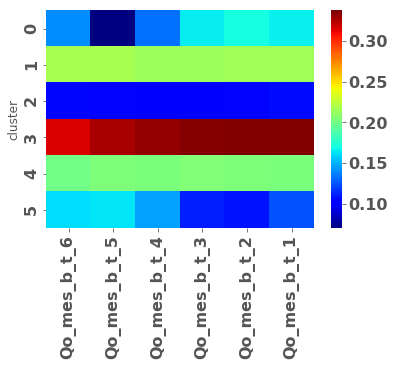

In [89]:
sns.heatmap(df_train.groupby('cluster')[[ 'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1']].mean(),cmap='jet')

### Correlacion con respecto a mi variable predictiva

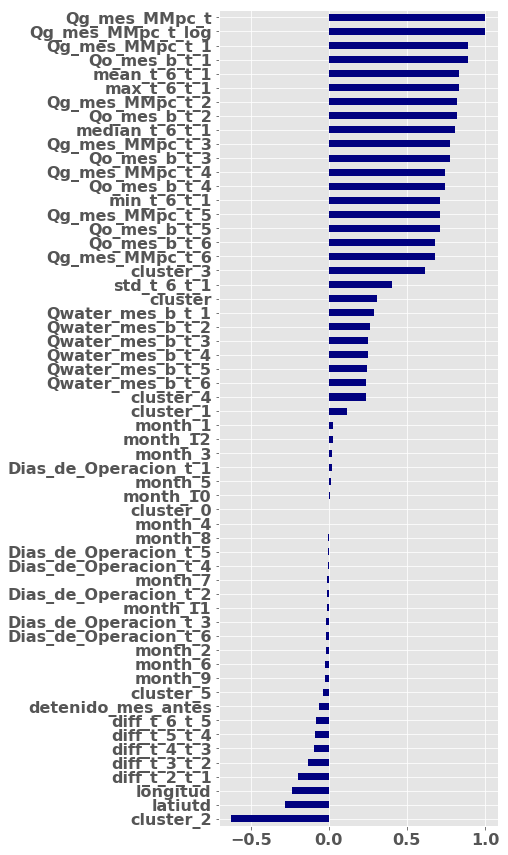

In [91]:
df_train.corrwith(df_train.Qg_mes_MMpc_t).sort_values().plot.barh(color='navy', figsize=(5,15))

# Entrenamiento

In [92]:
# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [93]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'Qg_mes_MMpc_t', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'c

In [95]:
num_cols = ['Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5',
       'Qg_mes_MMpc_t_4', 'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2',
       'Qg_mes_MMpc_t_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1',
       'mean_t_6_t_1', 'median_t_6_t_1', 'min_t_6_t_1', 'max_t_6_t_1',
       'Dias_de_Operacion_t_6', 'Dias_de_Operacion_t_5',
       'Dias_de_Operacion_t_4', 'Dias_de_Operacion_t_3',
       'Dias_de_Operacion_t_2', 'Dias_de_Operacion_t_1', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'Qo_mes_b_t_6', 'Qo_mes_b_t_5', 'Qo_mes_b_t_4', 'Qo_mes_b_t_3',
       'Qo_mes_b_t_2', 'Qo_mes_b_t_1', 'Qwater_mes_b_t_6', 'Qwater_mes_b_t_5',
       'Qwater_mes_b_t_4', 'Qwater_mes_b_t_3', 'Qwater_mes_b_t_2',
       'Qwater_mes_b_t_1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'latiutd', 'longitud']

In [98]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, num_cols, 'Qg_mes_MMpc_t')

In [99]:
x_train.shape

(13296, 55)

In [100]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.8
params['num_leaves'] = 25
params['min_data'] = 10
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 100, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[6305]	valid_0's l1: 0.0174646


In [101]:
clf.num_trees()

6305

# Evaluacion

In [102]:
y_pred = clf.predict(x_valid)

In [103]:
st.report_evaluation_regression(y_valid, y_pred)

R*2: 0.8239
MEA: 0.0162
MSE 0.001
RMSE 0.037


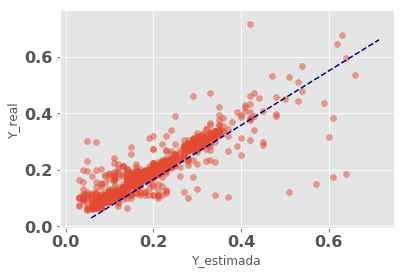

In [104]:
st.yy_plot(y_valid, y_pred)

## Residuos

In [105]:
res = (y_valid - y_pred) / y_valid

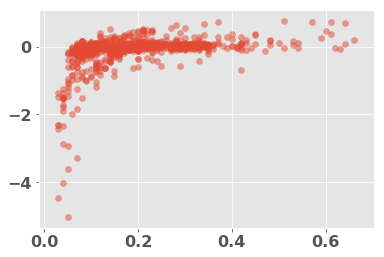

In [106]:
plt.scatter(y_valid, res, alpha=0.5)

In [107]:
df_train.loc[res[res<-5].index]

,Pozo,fecha_produccion,Qg_mes_MMpc_t_6,Qg_mes_MMpc_t_5,Qg_mes_MMpc_t_4,Qg_mes_MMpc_t_3,Qg_mes_MMpc_t_2,Qg_mes_MMpc_t_1,Qg_mes_MMpc_t,diff_t_6_t_5,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latiutd,longitud,Qg_mes_MMpc_t_log
7925,MOLOACAN-421,2014-02-01,0.29,0.32,0.31,0.32,0.31,0.32,0.05,-0.03,...,0,0,0,1,0,0,3,18.014716,-94.344038,0.04879


In [108]:
res[res<-5]

7925   -5.037429
Name: Qg_mes_MMpc_t, dtype: float64

# Interpretacion

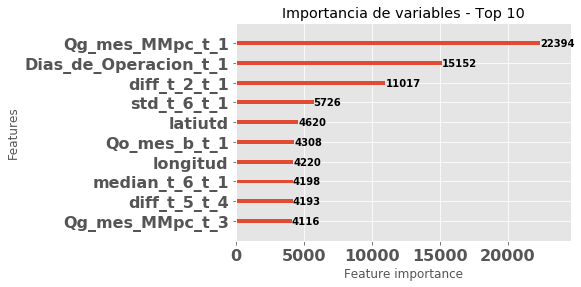

In [109]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [110]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [111]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [112]:
a = pd.DataFrame(clf.feature_importance(),index=x_valid.columns,
             columns=['imp']).sort_values('imp')

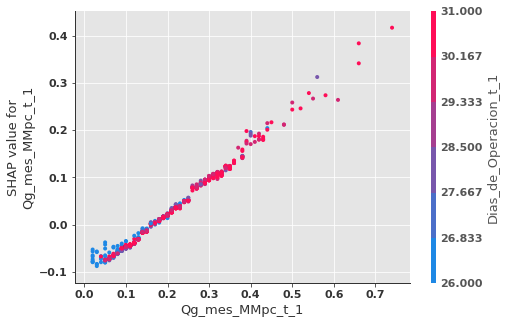

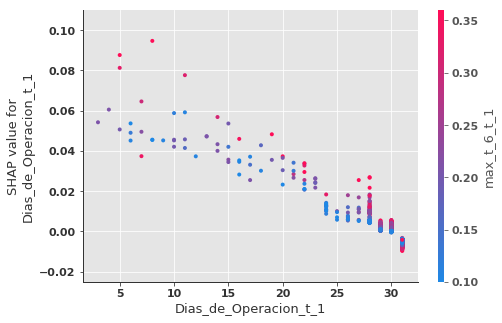

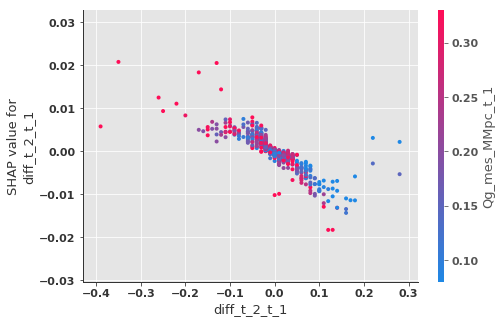

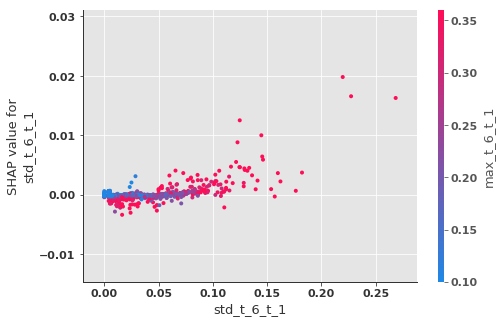

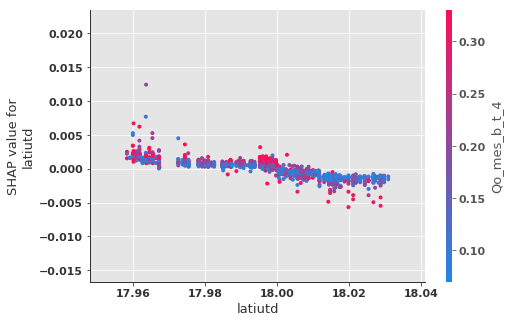

In [113]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

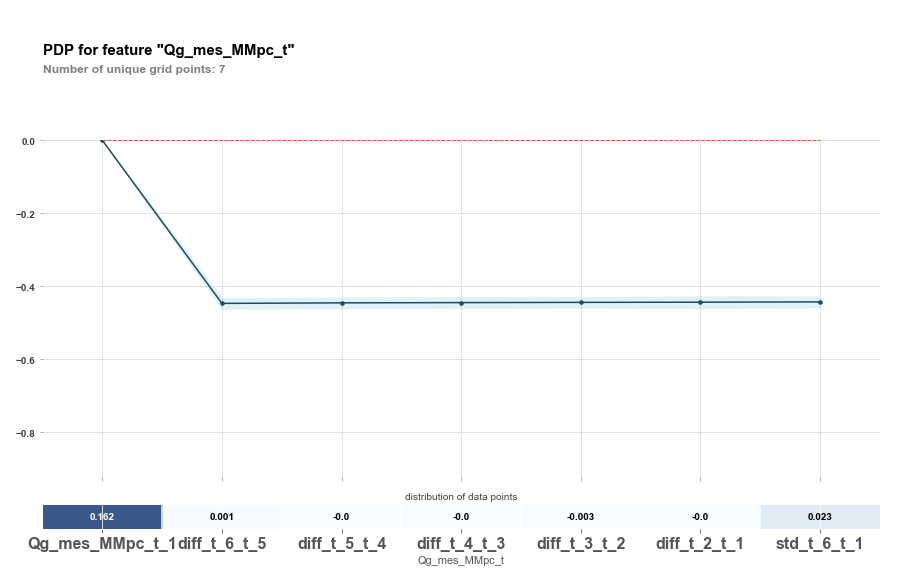

In [127]:
pdp_fare = pdp.pdp_isolate(
    model=clf, dataset=x_valid, model_features=num_cols, feature=num_cols[5:12])
fig, axes = pdp.pdp_plot(pdp_fare, 'Qg_mes_MMpc_t', plot_pts_dist=True)

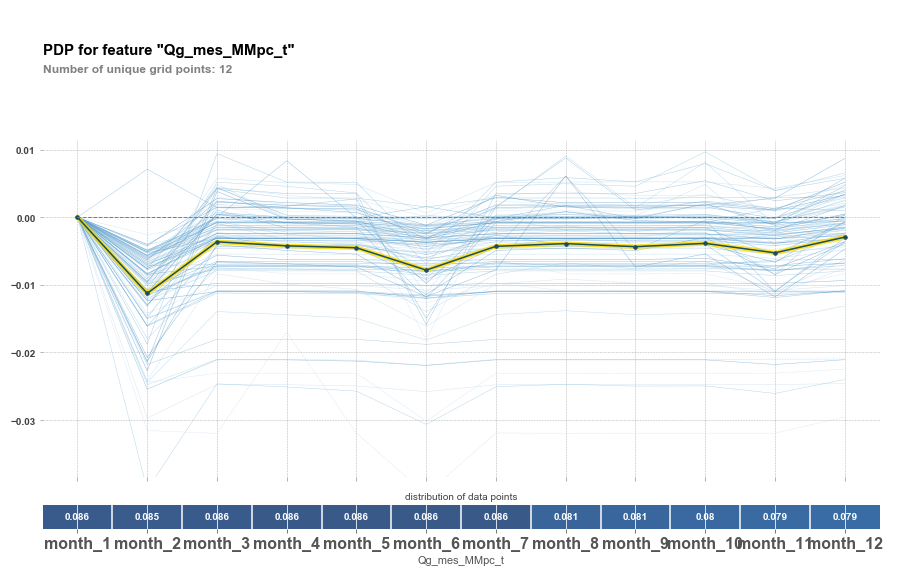

In [128]:
pdp_race = pdp.pdp_isolate(
    model=clf, dataset=df_train,    
    model_features=num_cols, 
    feature=[i for i in ['month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12']])
fig, axes = pdp.pdp_plot(pdp_race, 'Qg_mes_MMpc_t', center=True, 
                         plot_lines=True, frac_to_plot=100,  
                         plot_pts_dist=True)

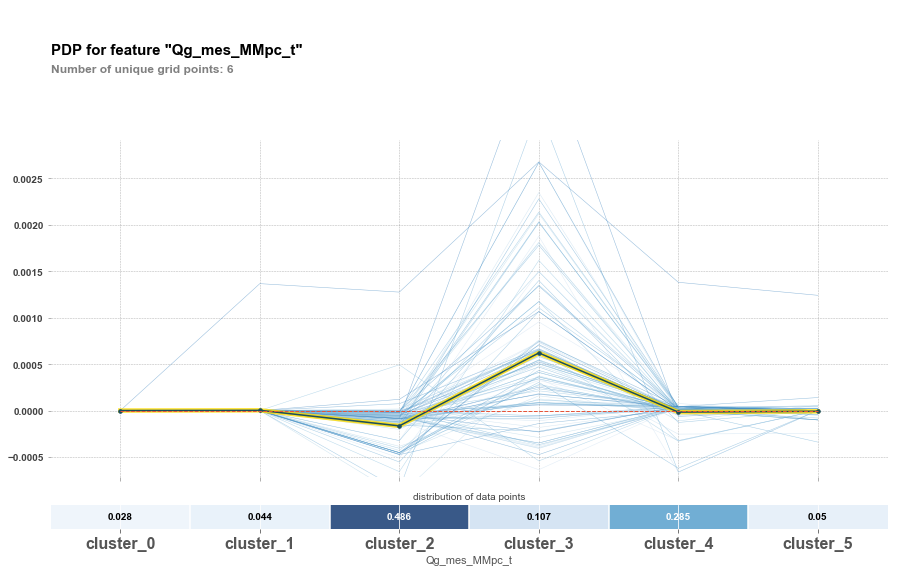

In [129]:
pdp_race = pdp.pdp_isolate(
    model=clf, dataset=df_train,    
    model_features=num_cols, 
    feature=[i for i in ['cluster_0', 'cluster_1', 
                         'cluster_2', 'cluster_3', 'cluster_4',
                         'cluster_5']])
fig, axes = pdp.pdp_plot(pdp_race, 'Qg_mes_MMpc_t', center=True, 
                         plot_lines=True, frac_to_plot=100,  
                         plot_pts_dist=True)

# Check de pozos aleatorios

In [130]:
idx = df_train.Pozo.sample(10)

In [131]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc_t.first().index

In [132]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc_t.first().unstack(0)

In [133]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [134]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

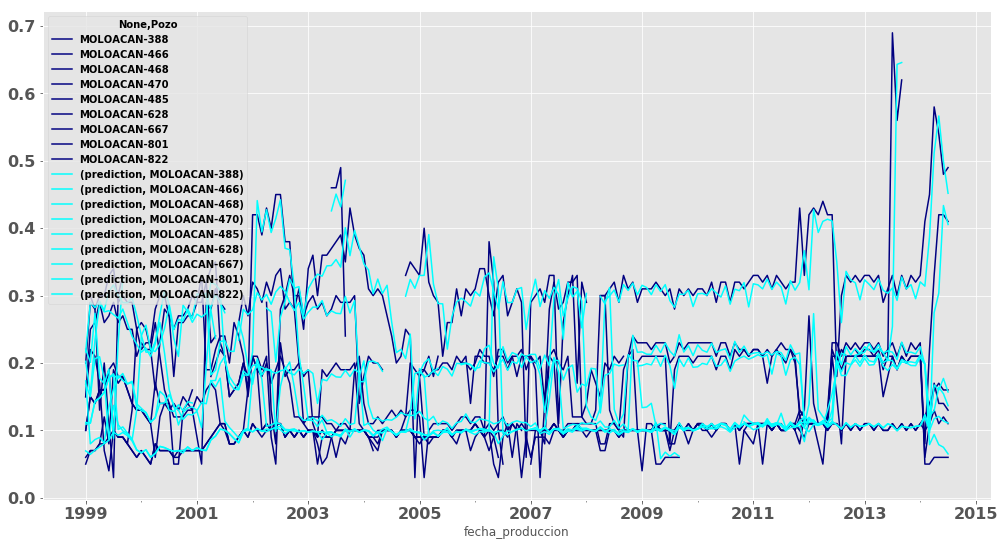

In [135]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [136]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [137]:
preds = clf.predict(df_train[num_cols])
real = df_train.Qg_mes_MMpc_t

In [138]:
df_train['prediction'] = preds

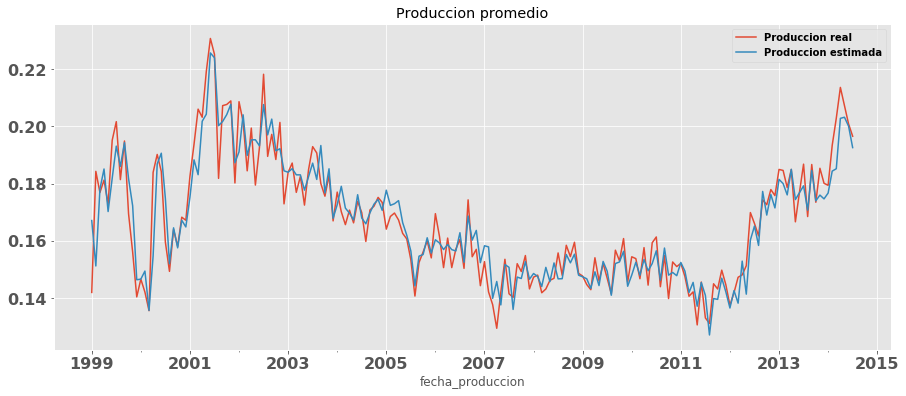

In [139]:
df_train.groupby('fecha_produccion')[['Qg_mes_MMpc_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Generador de serie de tiempo

In [140]:
df_train.head()

,Pozo,fecha_produccion,Qg_mes_MMpc_t_6,Qg_mes_MMpc_t_5,Qg_mes_MMpc_t_4,Qg_mes_MMpc_t_3,Qg_mes_MMpc_t_2,Qg_mes_MMpc_t_1,Qg_mes_MMpc_t,diff_t_6_t_5,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latiutd,longitud,Qg_mes_MMpc_t_log,prediction
200,MOLOACAN-111,1999-01-01,0.10,0.10,0.20,0.16,0.14,0.12,0.10,0.00,...,0,1,0,0,0,2,17.985929,-94.370707,0.095310,0.119523
201,MOLOACAN-111,1999-02-01,0.10,0.20,0.16,0.14,0.12,0.10,0.13,-0.10,...,0,1,0,0,0,2,17.985929,-94.370707,0.122218,0.115414
202,MOLOACAN-111,1999-03-01,0.20,0.16,0.14,0.12,0.10,0.13,0.14,0.04,...,0,1,0,0,0,2,17.985929,-94.370707,0.131028,0.127980
203,MOLOACAN-111,1999-04-01,0.16,0.14,0.12,0.10,0.13,0.14,0.15,0.02,...,0,1,0,0,0,2,17.985929,-94.370707,0.139762,0.152213
204,MOLOACAN-111,1999-05-01,0.14,0.12,0.10,0.13,0.14,0.15,0.15,0.02,...,0,1,0,0,0,2,17.985929,-94.370707,0.139762,0.140717
